This notebook implements the preprocessing pipeline described in the research article "Enhancing Time Series Product Demand Forecasting With Hybrid Attention-Based Deep Learning Models" (Section V.A). The goal is to prepare the "Predict Future Sales" dataset for training the HA-LSTM model, handling outliers, negative sales, missing values, and creating features for monthly sales forecasting.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from scipy.stats import mstats
import warnings
warnings.filterwarnings('ignore')

# Load dataset
train_data = pd.read_csv("/Users/mohammednihal/Desktop/XAI/Predict Future Sales/merged_data.csv")

# Convert date to datetime
train_data['date'] = pd.to_datetime(train_data['date'], format='%d.%m.%Y')

# Remove duplicates
print(f"Duplicate Records: {train_data.duplicated().sum()}")
train_data = train_data.drop_duplicates()
print(f"Dataset Shape after removing duplicates: {train_data.shape}")

# Impute missing item_name
print("\nMissing Values:")
print(train_data.isna().sum())
train_data['item_name'] = train_data['item_name'].fillna("Unknown")
print("\nMissing Values after imputation:")
print(train_data.isna().sum())

# Display basic statistics
print("\nBasic Statistics:")
print(train_data.describe())
print("\nNumber of Unique Shops:", train_data['shop_id'].nunique())
print("Number of Unique Items:", train_data['item_id'].nunique())

Duplicate Records: 6
Dataset Shape after removing duplicates: (2935843, 10)

Missing Values:
date                   0
date_block_num         0
shop_id                0
item_id                0
item_price             0
item_cnt_day           0
item_name             84
item_category_id       0
item_category_name     0
shop_name              0
dtype: int64

Missing Values after imputation:
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

Basic Statistics:
                             date  date_block_num       shop_id       item_id  \
count                     2935843    2.935843e+06  2.935843e+06  2.935843e+06   
mean   2014-04-03 05:44:38.044160    1.456991e+01  3.300171e+01  1.019723e+04   
min           2013-01-01 00:00:00    0.000000e+00  0.000000e+00  0.000000e+00   
25%           

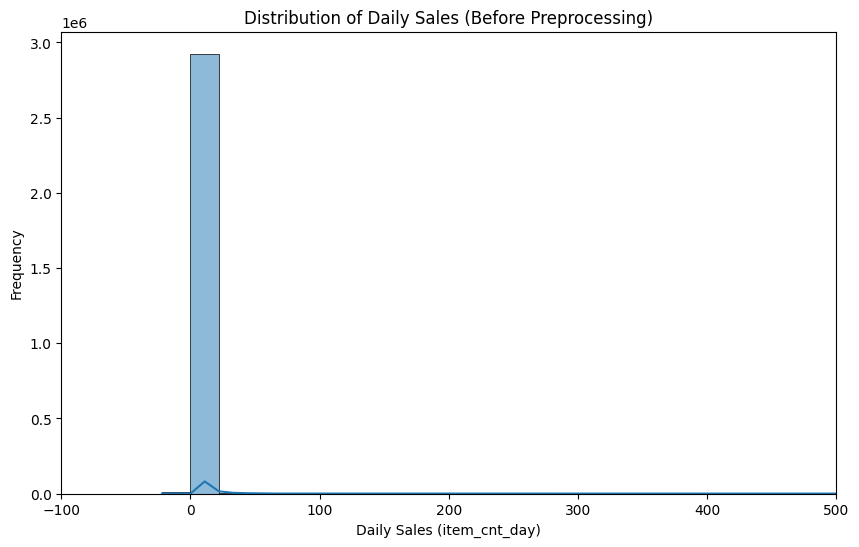

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['item_cnt_day'], bins=100, kde=True)
plt.title('Distribution of Daily Sales (Before Preprocessing)')
plt.xlabel('Daily Sales (item_cnt_day)')
plt.ylabel('Frequency')
plt.xlim(-100, 500)
plt.show()

In [8]:
shop_names = train_data[['shop_id', 'shop_name']].drop_duplicates()
duplicate_names = shop_names['shop_name'].str.lower().str.strip().duplicated().sum()
print(f"Duplicate Shop Names (case-insensitive): {duplicate_names}")

# Calculate shop sales and activity
shop_sales = train_data.groupby('shop_id').agg({
    'item_cnt_day': 'sum',
    'date': lambda x: x.dt.to_period('M').nunique(),
    'shop_name': 'first'
}).rename(columns={'item_cnt_day': 'total_sales', 'date': 'active_months'}).reset_index()

print("\nShop Sales and Activity Statistics:")
print(shop_sales.describe())

# Identify low-sale or low-activity shops
low_sale_shops = shop_sales[shop_sales['total_sales'] < shop_sales['total_sales'].quantile(0.05)]
low_activity_shops = shop_sales[shop_sales['active_months'] < shop_sales['active_months'].quantile(0.05)]
print(f"\nLow-Sale Shops (bottom 5%): {len(low_sale_shops)}")
print(f"Low-Activity Shops (bottom 5%): {len(low_activity_shops)}")

# Select top 54 shops
top_shops = shop_sales.sort_values(['total_sales', 'active_months'], ascending=False).head(54)['shop_id'].tolist()
print(f"Selected {len(top_shops)} shops.")

# Filter dataset
train_data = train_data[train_data['shop_id'].isin(top_shops)]
print("Dataset Shape after shop selection:", train_data.shape)

Duplicate Shop Names (case-insensitive): 0

Shop Sales and Activity Statistics:
         shop_id    total_sales  active_months
count  60.000000      60.000000      60.000000
mean   29.500000   60803.333333      26.433333
std    17.464249   57992.776412      11.566120
min     0.000000     330.000000       1.000000
25%    14.750000   23333.000000      20.000000
50%    29.500000   50176.000000      34.000000
75%    44.250000   69562.250000      34.000000
max    59.000000  310777.000000      34.000000

Low-Sale Shops (bottom 5%): 3
Low-Activity Shops (bottom 5%): 2
Selected 54 shops.
Dataset Shape after shop selection: (2920550, 10)


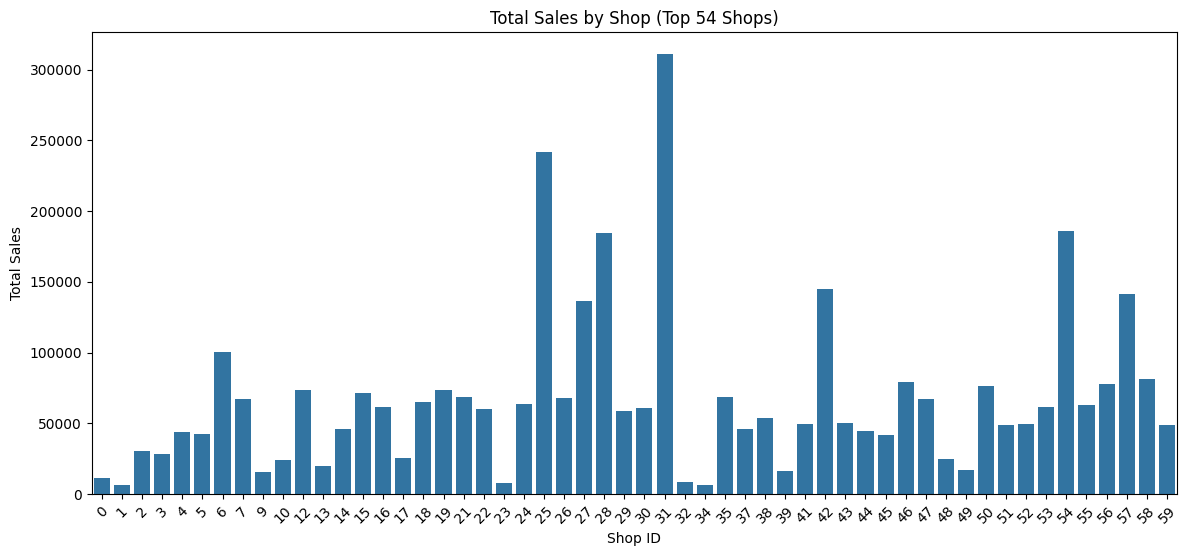

In [9]:
plt.figure(figsize=(14, 6))
sns.barplot(data=shop_sales[shop_sales['shop_id'].isin(top_shops)], x='shop_id', y='total_sales')
plt.title('Total Sales by Shop (Top 54 Shops)')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [12]:
print("Applying Winsorization for outliers...")
from scipy.stats import mstats
import numpy as np

# Sort data for consistency
train_data = train_data.sort_values(['shop_id', 'item_id', 'date'])

# Simple Winsorization at 99th percentile
def simple_winsorize(df):
    # Compute global 99th percentile for item_cnt_day
    upper_limit = df['item_cnt_day'].quantile(0.99)
    # Clip values above 99th percentile
    df['item_cnt_day_winsor'] = np.minimum(df['item_cnt_day'], upper_limit)
    # Flag outliers
    df['is_outlier'] = df['item_cnt_day'] > upper_limit
    return df

try:
    train_data = simple_winsorize(train_data)
except MemoryError:
    print("MemoryError during Winsorization. Using chunked processing...")
    chunks = [train_data.iloc[i:i+100000] for i in range(0, len(train_data), 100000)]
    train_data = pd.concat([simple_winsorize(chunk) for chunk in chunks])

# Statistics on outliers
outlier_count = train_data['is_outlier'].sum()
outlier_percentage = (outlier_count / len(train_data)) * 100
print(f"Number of outliers detected: {outlier_count} ({outlier_percentage:.2f}%)")

train_data = train_data.drop(columns=['is_outlier'])

Applying Winsorization for outliers...
Number of outliers detected: 27098 (0.93%)


In [15]:
print("Handling negative sales values...")
negative_sales = (train_data['item_cnt_day_winsor'] < 0).sum()
negative_percentage = (negative_sales / len(train_data)) * 100
print(f"Negative sales records: {negative_sales} ({negative_percentage:.2f}%)")

train_data['returns'] = train_data['item_cnt_day_winsor'].apply(lambda x: abs(x) if x < 0 else 0)
train_data['item_cnt_day_winsor'] = train_data['item_cnt_day_winsor'].apply(lambda x: max(0, x))

print("Negative sales after processing:", (train_data['item_cnt_day_winsor'] < 0).sum())

plt.figure(figsize=(10, 6))
plt.hist(train_data['returns'], bins=100, alpha=0.7, range=(0, 50))
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.savefig('returns_distribution.png')
plt.close()

Handling negative sales values...
Negative sales records: 7311 (0.25%)
Negative sales after processing: 0


In [16]:
print("Aggregating to monthly level...")
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
monthly_sales = train_data.groupby([
    'year', 'month', 'shop_id', 'item_id', 'item_category_id', 'item_name', 'item_category_name', 'shop_name'
]).agg({
    'item_cnt_day_winsor': 'sum',
    'returns': 'sum',
    'item_price': 'mean',
    'date_block_num': 'first'
}).reset_index()

monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

# Verify no duplicate dates
duplicate_dates = monthly_sales.duplicated(subset=['date', 'shop_id', 'item_id']).sum()
print(f"Duplicate date-shop-item combinations: {duplicate_dates}")

plt.figure(figsize=(12, 6))
monthly_totals = monthly_sales.groupby('date')['item_cnt_day_winsor'].sum()
plt.plot(monthly_totals.index, monthly_totals.values)
plt.title('Total Monthly Sales (After Aggregation)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.savefig('monthly_sales.png')
plt.close()

Aggregating to monthly level...
Duplicate date-shop-item combinations: 0


In [17]:
print("Creating lag features...")
def create_lag_features(df, lags=[1, 2, 3]):
    df = df.sort_values(['shop_id', 'item_id', 'date'])
    for lag in lags:
        df[f'lag_sales_{lag}'] = df.groupby(['shop_id', 'item_id'])['item_cnt_day_winsor'].shift(lag)
        df[f'lag_returns_{lag}'] = df.groupby(['shop_id', 'item_id'])['returns'].shift(lag)
        df[f'lag_price_{lag}'] = df.groupby(['shop_id', 'item_id'])['item_price'].shift(lag)
    return df

try:
    monthly_sales = create_lag_features(monthly_sales)
except MemoryError:
    print("MemoryError during lag feature creation. Using chunked processing...")
    chunks = [monthly_sales.iloc[i:i+100000] for i in range(0, len(monthly_sales), 100000)]
    monthly_sales = pd.concat([create_lag_features(chunk) for chunk in chunks])

# Drop rows with missing lags
monthly_sales = monthly_sales.dropna()

print("Lag Features Statistics:")
print(monthly_sales[[f'lag_sales_{i}' for i in [1, 2, 3]]].describe())

Creating lag features...
Lag Features Statistics:
         lag_sales_1    lag_sales_2    lag_sales_3
count  710170.000000  710170.000000  710170.000000
mean        2.360246       2.623814       2.941076
std         4.712349       5.120811       5.589527
min         0.000000       0.000000       0.000000
25%         1.000000       1.000000       1.000000
50%         1.000000       1.000000       1.000000
75%         2.000000       3.000000       3.000000
max       155.000000     155.000000     155.000000


In [ ]:
print("Encoding categorical variables...")
monthly_sales = pd.get_dummies(
    monthly_sales,
    columns=['shop_id', 'item_id', 'item_category_id'],
    prefix=['shop', 'item', 'category']
)

print("Dataset Shape after encoding:", monthly_sales.shape)

Encoding categorical variables...
Dataset Shape after encoding: (710170, 12943)


In [19]:
print("Applying robust scaling...")
from sklearn.preprocessing import RobustScaler

# Optimize dtypes
monthly_sales = monthly_sales.astype({
    'item_cnt_day_winsor': 'float32', 'returns': 'float32', 'item_price': 'float32',
    'lag_sales_1': 'float32', 'lag_sales_2': 'float32', 'lag_sales_3': 'float32',
    'lag_returns_1': 'float32', 'lag_returns_2': 'float32', 'lag_returns_3': 'float32',
    'lag_price_1': 'float32', 'lag_price_2': 'float32', 'lag_price_3': 'float32',
    'year': 'int16', 'month': 'int8'
}, errors='ignore')

numerical_cols = [
    'item_cnt_day_winsor', 'returns', 'item_price',
    'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
    'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
    'lag_price_1', 'lag_price_2', 'lag_price_3'
]

# Apply scaling column-by-column
scaler = RobustScaler(copy=False)
for col in numerical_cols:
    try:
        monthly_sales[col] = scaler.fit_transform(monthly_sales[[col]].values).ravel()
    except MemoryError:
        print(f"MemoryError scaling {col}. Using chunked processing...")
        chunks = [monthly_sales[[col]].iloc[i:i+100000] for i in range(0, len(monthly_sales), 100000)]
        scaled_chunks = [scaler.fit_transform(chunk.values).ravel() for chunk in chunks]
        monthly_sales[col] = np.concatenate(scaled_chunks)
        
plt.figure(figsize=(10, 6))
plt.hist(monthly_sales['item_cnt_day_winsor'], bins=100, density=True, alpha=0.7)
plt.title('Scaled Monthly Sales Distribution')
plt.xlabel('Scaled Sales')
plt.ylabel('Density')
plt.savefig('scaled_sales_distribution.png')
plt.close()

Applying robust scaling...


In [20]:
print("Splitting dataset...")
test_start = pd.to_datetime('2015-08-01')
val_start = pd.to_datetime('2015-09-01')

# Set date as index for faster filtering
monthly_sales.set_index('date', inplace=True)

# Split using boolean indexing
train_mask = monthly_sales.index < test_start
val_mask = (monthly_sales.index >= test_start) & (monthly_sales.index < val_start)
test_mask = monthly_sales.index >= val_start

try:
    train_data = monthly_sales[train_mask].copy()
    val_data = monthly_sales[val_mask].copy()
    test_data = monthly_sales[test_mask].copy()
except MemoryError:
    print("MemoryError during splitting. Using chunked processing...")
    train_data = monthly_sales[train_mask].compute() if hasattr(monthly_sales, 'compute') else monthly_sales[train_mask].copy()
    val_data = monthly_sales[val_mask].compute() if hasattr(monthly_sales, 'compute') else monthly_sales[val_mask].copy()
    test_data = monthly_sales[test_mask].compute() if hasattr(monthly_sales, 'compute') else monthly_sales[test_mask].copy()

# Reset index
train_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

# Select feature columns (exclude one-hot encoded columns)
feature_cols = [
    'date_block_num', 'shop_id', 'item_id', 'item_category_id',
    'item_price', 'returns', 'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
    'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
    'lag_price_1', 'lag_price_2', 'lag_price_3'
]
text_cols = ['date', 'item_name', 'item_category_name', 'shop_name']

# Define datasets
X_train = train_data[feature_cols]
y_train = train_data['item_cnt_day_winsor']
X_val = val_data[feature_cols]
y_val = val_data['item_cnt_day_winsor']
X_test = test_data[feature_cols]
y_test = test_data['item_cnt_day_winsor']
train_text = train_data[text_cols]
val_text = val_data[text_cols]
test_text = test_data[text_cols]

print(f"Training set size: {len(X_train)} records")
print(f"Validation set size: {len(X_val)} records")
print(f"Test set size: {len(X_test)} records")

# Lightweight bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation', 'Test'], [len(X_train), len(X_val), len(X_test)])
plt.title('Dataset Sizes')
plt.ylabel('Number of Records')
plt.savefig('dataset_sizes.png')
plt.close()

Splitting dataset...
Training set size: 653664 records
Validation set size: 20806 records
Test set size: 35700 records


In [21]:
print("Saving processed datasets...")
import pyarrow.parquet as pq
import pyarrow as pa
import shutil

# Function to save DataFrame in chunks
def save_parquet_chunks(df, filename, chunk_size=100000):
    try:
        table = pa.Table.from_pandas(df)
        pq.write_table(table, filename, compression='gzip', row_group_size=chunk_size)
        print(f"Saved {filename}")
    except OSError as e:
        print(f"Error saving {filename}: {e}")
        raise

# Check disk space
total, used, free = shutil.disk_usage('/')
free_gb = free / (2**30)
print(f"Available disk space: {free_gb:.2f} GiB")
if free_gb < 15:
    print("Warning: Low disk space. Free up at least 15 GiB for safe saving.")

# Save datasets
save_parquet_chunks(X_train, 'X_train_processed.parquet')
save_parquet_chunks(y_train.to_frame(), 'y_train_processed.parquet')
save_parquet_chunks(X_val, 'X_val_processed.parquet')
save_parquet_chunks(y_val.to_frame(), 'y_val_processed.parquet')
save_parquet_chunks(X_test, 'X_test_processed.parquet')
save_parquet_chunks(y_test.to_frame(), 'y_test_processed.parquet')
save_parquet_chunks(train_text, 'train_text.parquet')
save_parquet_chunks(val_text, 'val_text.parquet')
save_parquet_chunks(test_text, 'test_text.parquet')

print("Preprocessing complete! Dataset is ready for training and future interpretability tasks.")

Saving processed datasets...
Available disk space: 39.96 GiB
Saved X_train_processed.parquet
Saved y_train_processed.parquet
Saved X_val_processed.parquet
Saved y_val_processed.parquet
Saved X_test_processed.parquet
Saved y_test_processed.parquet
Saved train_text.parquet
Saved val_text.parquet
Saved test_text.parquet
Preprocessing complete! Dataset is ready for training and future interpretability tasks.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from uuid import uuid4
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset
class SalesDataset(Dataset):
    def __init__(self, X_file, y_file, sequence_length=12):
        self.X = pd.read_csv(X_file)
        self.y = pd.read_csv(y_file)
        self.sequence_length = sequence_length
        self.feature_cols = [col for col in self.X.columns if col not in ['date_block_num', 'returns']]
        self.id_cols = ['shop_id', 'item_id', 'date_block_num']
        
        # Group by shop_id, item_id to create sequences
        self.groups = self.X.groupby(['shop_id', 'item_id'])
        self.group_keys = list(self.groups.groups.keys())
        
    def __len__(self):
        return len(self.group_keys)
    
    def __getitem__(self, idx):
        shop_id, item_id = self.group_keys[idx]
        group = self.groups.get_group((shop_id, item_id)).sort_values('date_block_num')
        
        # Extract sequences
        if len(group) < self.sequence_length:
            # Pad with zeros if sequence is too short
            padding = pd.DataFrame(0, index=range(self.sequence_length - len(group)), columns=group.columns)
            group = pd.concat([padding, group], ignore_index=True)
        
        # Get last sequence_length time steps
        group = group.tail(self.sequence_length)
        
        features = group[self.feature_cols].values.astype(np.float32)
        target = self.y.loc[group.index[-1]].values.astype(np.float32)
        date_block_num = group['date_block_num'].iloc[-1]
        identifiers = group[self.id_cols].iloc[-1].values
        
        return {
            'features': torch.tensor(features, dtype=torch.float32),
            'target': torch.tensor(target, dtype=torch.float32),
            'date_block_num': torch.tensor(date_block_num, dtype=torch.int32),
            'identifiers': torch.tensor(identifiers, dtype=torch.int32)
        }

# Feature Attention Layer
class FeatureAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim=64):
        super(FeatureAttention, self).__init__()
        self.query = nn.Linear(feature_dim, attention_dim)
        self.key = nn.Linear(feature_dim, attention_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = 1 / (attention_dim ** 0.5)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # x: (batch, seq_len, feature_dim)
        query = self.query(x)  # (batch, seq_len, attention_dim)
        key = self.key(x)      # (batch, seq_len, attention_dim)
        value = self.value(x)  # (batch, seq_len, feature_dim)
        
        scores = torch.bmm(query, key.transpose(1, 2)) * self.scale  # (batch, seq_len, seq_len)
        weights = self.softmax(scores)  # (batch, seq_len, seq_len)
        output = torch.bmm(weights, value)  # (batch, seq_len, feature_dim)
        
        return output, weights

# Modified HA-LSTM Model
class HALSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_heads=4, dropout=0.1):
        super(HALSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Feature Attention
        self.feature_attention = FeatureAttention(input_dim)
        
        # Embedding layers for categorical features
        self.shop_embed = nn.Embedding(54, 16)
        self.item_embed = nn.Embedding(21807, 64)
        self.category_embed = nn.Embedding(84, 16)
        self.embed_dim = 16 + 64 + 16  # Total embedding dimension
        
        # LSTM Encoder
        self.lstm = nn.LSTM(input_dim + self.embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Multi-Head Attention
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        
        # Gated Fusion Layer
        self.gate = nn.Linear(hidden_dim * 2, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Output Layer
        self.fc = nn.Linear(hidden_dim, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, shop_ids, item_ids, category_ids):
        batch_size, seq_len, _ = x.size()
        
        # Embed categorical features
        shop_embed = self.shop_embed(shop_ids)  # (batch, seq_len, 16)
        item_embed = self.item_embed(item_ids)  # (batch, seq_len, 64)
        category_embed = self.category_embed(category_ids)  # (batch, seq_len, 16)
        embeddings = torch.cat([shop_embed, item_embed, category_embed], dim=-1)  # (batch, seq_len, 96)
        
        # Concatenate embeddings with input features
        x = torch.cat([x, embeddings], dim=-1)  # (batch, seq_len, input_dim + 96)
        
        # Feature Attention
        x, feature_weights = self.feature_attention(x)  # (batch, seq_len, input_dim + 96), (batch, seq_len, seq_len)
        x = self.dropout(x)
        
        # LSTM Encoder
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))  # (batch, seq_len, hidden_dim)
        lstm_out = self.dropout(lstm_out)
        
        # Multi-Head Attention
        mha_out, mha_weights = self.mha(lstm_out, lstm_out, lstm_out)  # (batch, seq_len, hidden_dim), (batch, seq_len, seq_len)
        mha_out = self.dropout(mha_out)
        
        # Gated Fusion Layer
        combined = torch.cat([lstm_out[:, -1, :], mha_out[:, -1, :]], dim=-1)  # (batch, hidden_dim * 2)
        gate = self.sigmoid(self.gate(combined))  # (batch, hidden_dim)
        fused = gate * lstm_out[:, -1, :] + (1 - gate) * mha_out[:, -1, :]  # (batch, hidden_dim)
        
        # Output Layer
        output = self.fc(fused)  # (batch, 1)
        
        return output, {
            'feature_weights': feature_weights,
            'mha_weights': mha_weights,
            'gated_output': fused,
            'gate_weights': gate
        }

# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Storage for interpretAbyility outputs
    interpret_outputs = {
        'sample_id': [],
        'shop_id': [],
        'item_id': [],
        'date_block_num': [],
        'feature_weights': [],
        'mha_weights': [],
        'gated_output': [],
        'gate_weights': []
    }
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            features = batch['features'].to(device)
            target = batch['target'].to(device)
            shop_ids = batch['identifiers'][:, 0].to(device)
            item_ids = batch['identifiers'][:, 1].to(device)
            category_ids = batch['identifiers'][:, 2].to(device)
            date_block_num = batch['date_block_num'].to(device)
            identifiers = batch['identifiers'].to(device)
            
            optimizer.zero_grad()
            output, interpret_data = model(features, shop_ids, item_ids, category_ids)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Store interpretability outputs
            sample_id = str(uuid4())
            interpret_outputs['sample_id'].append(sample_id)
            interpret_outputs['shop_id'].append(shop_ids.cpu().numpy()[0])
            interpret_outputs['item_id'].append(item_ids.cpu().numpy()[0])
            interpret_outputs['date_block_num'].append(date_block_num.cpu().numpy()[0])
            interpret_outputs['feature_weights'].append(interpret_data['feature_weights'].detach().cpu().numpy())
            interpret_outputs['mha_weights'].append(interpret_data['mha_weights'].detach().cpu().numpy())
            interpret_outputs['gated_output'].append(interpret_data['gated_output'].detach().cpu().numpy())
            interpret_outputs['gate_weights'].append(interpret_data['gate_weights'].detach().cpu().numpy())
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                target = batch['target'].to(device)
                shop_ids = batch['identifiers'][:, 0].to(device)
                item_ids = batch['identifiers'][:, 1].to(device)
                category_ids = batch['identifiers'][:, 2].to(device)
                
                output, _ = model(features, shop_ids, item_ids, category_ids)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_ha_lstm.pth')
    
    # Save interpretability outputs
    interpret_df = pd.DataFrame({
        'sample_id': interpret_outputs['sample_id'],
        'shop_id': interpret_outputs['shop_id'],
        'item_id': interpret_outputs['item_id'],
        'date_block_num': interpret_outputs['date_block_num']
    })
    np.save('feature_weights.npy', np.stack(interpret_outputs['feature_weights']))
    np.save('mha_weights.npy', np.stack(interpret_outputs['mha_weights']))
    np.save('gated_output.npy', np.stack(interpret_outputs['gated_output']))
    np.save('gate_weights.npy', np.stack(interpret_outputs['gate_weights']))
    interpret_df.to_csv('interpret_indices.csv', index=False)
    
    return model

# Main execution
if __name__ == "__main__":
    # Dataset paths
    train_X = 'X_train_processed.csv'
    train_y = 'y_train_processed.csv'
    val_X = 'X_val_processed.csv'
    val_y = 'y_val_processed.csv'
    
    # Hyperparameters
    sequence_length = 12
    batch_size = 64
    input_dim = pd.read_csv(train_X).shape[1] - 3  # Exclude shop_id, item_id, date_block_num
    hidden_dim = 128
    num_layers = 2
    num_heads = 4
    num_epochs = 50
    lr = 0.001
    
    # Create datasets and loaders
    train_dataset = SalesDataset(train_X, train_y, sequence_length)
    val_dataset = SalesDataset(val_X, val_y, sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = HALSTM(input_dim, hidden_dim, num_layers, num_heads).to(device)
    
    # Train model
    model = train_model(model, train_loader, val_loader, num_epochs, lr)
    
    # Plot attention weights (example for first batch)
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        features = batch['features'].to(device)
        shop_ids = batch['identifiers'][:, 0].to(device)
        item_ids = batch['identifiers'][:, 1].to(device)
        category_ids = batch['identifiers'][:, 2].to(device)
        _, interpret_data = model(features, shop_ids, item_ids, category_ids)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(interpret_data['feature_weights'][0].cpu().numpy(), cmap='viridis')
        plt.title('Feature Attention Weights (First Sample)')
        plt.xlabel('Feature Index')
        plt.ylabel('Sequence Position')
        plt.savefig('feature_attention.png')
        plt.close()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(interpret_data['mha_weights'][0].cpu().numpy(), cmap='viridis')
        plt.title('Multi-Head Attention Weights (First Sample)')
        plt.xlabel('Time Step')
        plt.ylabel('Time Step')
        plt.savefig('mha_attention.png')
        plt.close()
    
    print("Training complete. Model and interpretability outputs saved.")

ModuleNotFoundError: No module named 'torch'